<a href="https://colab.research.google.com/github/KarolineKlan/deep_project_group_38/blob/main/notebooks/DirVAE_nyReparam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Det originale fra python scriptet.

---



In [ ]:
"""
Dirichlet Variational Auto-Encoder (Dir-VAE) implementation for MNIST
Based on "Autoencodeing Variational Inference for Topic Model" (ICLR2017)
"""

from __future__ import print_function

import argparse
import os
import sys
from dataclasses import dataclass
from typing import Tuple

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


@dataclass
class Config:
    """Configuration class for Dir-VAE training"""

    batch_size: int = 256
    epochs: int = 10
    learning_rate: float = 1e-3
    no_cuda: bool = False
    seed: int = 10
    log_interval: int = 2
    category: int = 10  # Number of latent categories (K)
    alpha: float = 0.3  # Dirichlet hyperparameter
    data_dir: str = "./data"
    output_dir: str = "./image"

    # Network architecture parameters
    encoder_channels: int = 64
    decoder_channels: int = 64
    input_channels: int = 1
    latent_dim: int = 1024
    hidden_dim: int = 512


def create_argument_parser() -> argparse.ArgumentParser:
    """Create and configure argument parser"""
    parser = argparse.ArgumentParser(description="Dir-VAE MNIST Example")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=256,
        metavar="N",
        help="input batch size for training (default: 256)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=10,
        metavar="N",
        help="number of epochs to train (default: 10)",
    )
    parser.add_argument(
        "--learning-rate",
        type=float,
        default=1e-3,
        help="learning rate (default: 1e-3)",
    )
    parser.add_argument(
        "--no-cuda", action="store_true", default=False, help="disable CUDA training"
    )
    parser.add_argument(
        "--seed", type=int, default=10, metavar="S", help="random seed (default: 10)"
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=2,
        metavar="N",
        help="how many batches to wait before logging training status",
    )
    parser.add_argument(
        "--category",
        type=int,
        default=10,
        metavar="K",
        help="the number of categories in the dataset",
    )
    parser.add_argument(
        "--alpha",
        type=float,
        default=0.3,
        help="Dirichlet hyperparameter alpha (default: 0.3)",
    )
    parser.add_argument(
        "--data-dir",
        type=str,
        default="./data",
        help="directory for dataset (default: ./data)",
    )
    parser.add_argument(
        "--output-dir",
        type=str,
        default="./image",
        help="directory for output images (default: ./image)",
    )
    return parser


def setup_device_and_seed(config: Config) -> torch.device:
    """Setup device and random seeds"""
    # Set random seeds for reproducibility
    torch.manual_seed(config.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(config.seed)

    # Determine device
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    print(f"Using device: {device}")
    return device


def create_data_loaders(
    config: Config,
) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """Create train and test data loaders"""
    # Create data directory if it doesn't exist
    os.makedirs(config.data_dir, exist_ok=True)

    # Data loader kwargs
    kwargs = (
        {"num_workers": 1, "pin_memory": True}
        if not config.no_cuda and torch.cuda.is_available()
        else {}
    )

    # Create datasets and loaders
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            config.data_dir, train=True, download=True, transform=transforms.ToTensor()
        ),
        batch_size=config.batch_size,
        shuffle=True,
        **kwargs,
    )

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(config.data_dir, train=False, transform=transforms.ToTensor()),
        batch_size=config.batch_size,
        shuffle=False,
        **kwargs,
    )

    return train_loader, test_loader


def compute_dirichlet_prior(
    K: int, alpha: float, device: torch.device
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute Dirichlet prior parameters using Laplace approximation.

    Args:
        K: Number of categories
        alpha: Dirichlet hyperparameter
        device: torch device

    Returns:
        Tuple of (mean, variance) tensors for the approximated normal distribution
    """
    # Laplace approximation to convert Dirichlet to multivariate normal
    a = torch.full((1, K), alpha, dtype=torch.float, device=device)
    mean = a.log().t() - a.log().mean(1, keepdim=True)
    var = ((1 - 2.0 / K) * a.reciprocal()).t() + (1.0 / K**2) * a.reciprocal().sum(
        1, keepdim=True
    )
    return mean.t(), var.t()


class DirVAEEncoder(nn.Module):
    """Encoder part of Dir-VAE"""

    def __init__(self, config: Config):
        super(DirVAEEncoder, self).__init__()
        ndf = config.encoder_channels
        nc = config.input_channels

        self.conv_layers = nn.Sequential(
            # input: (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, config.latent_dim, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc1 = nn.Linear(config.latent_dim, config.hidden_dim)
        self.fc_mu = nn.Linear(config.hidden_dim, config.category)
        self.fc_logvar = nn.Linear(config.hidden_dim, config.category)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        conv_out = self.conv_layers(x)
        h1 = self.fc1(conv_out.view(conv_out.size(0), -1))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar


class DirVAEDecoder(nn.Module):
    """Decoder part of Dir-VAE"""

    def __init__(self, config: Config):
        super(DirVAEDecoder, self).__init__()
        ngf = config.decoder_channels
        nc = config.input_channels

        self.fc_decode = nn.Linear(config.category, config.hidden_dim)
        self.fc_deconv = nn.Linear(config.hidden_dim, config.latent_dim)

        self.deconv_layers = nn.Sequential(
            # input: latent_dim x 1 x 1
            nn.ConvTranspose2d(config.latent_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Sigmoid(),
            # output: (nc) x 32 x 32
        )

        self.relu = nn.ReLU()

    def forward(self, gauss_z: torch.Tensor) -> torch.Tensor:
        # Apply softmax to satisfy simplex constraint (Dirichlet distribution)
        dir_z = F.softmax(gauss_z, dim=1)

        h3 = self.relu(self.fc_decode(dir_z))
        deconv_input = self.fc_deconv(h3)
        deconv_input = deconv_input.view(-1, deconv_input.size(1), 1, 1)

        return self.deconv_layers(deconv_input)


class DirVAE(nn.Module):
    """Dirichlet Variational Auto-Encoder"""

    def __init__(self, config: Config, device: torch.device):
        super(DirVAE, self).__init__()
        self.config = config
        self.device = device

        # Initialize encoder and decoder
        self.encoder = DirVAEEncoder(config)
        self.decoder = DirVAEDecoder(config)

        # Setup Dirichlet prior
        self._setup_dirichlet_prior()

    def _setup_dirichlet_prior(self):
        """Setup Dirichlet prior parameters"""
        prior_mean, prior_var = compute_dirichlet_prior(
            self.config.category, self.config.alpha, self.device
        )
        self.register_buffer("prior_mean", prior_mean)
        self.register_buffer("prior_var", prior_var)
        self.register_buffer("prior_logvar", prior_var.log())

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode input to latent parameters"""
        return self.encoder(x)

    def decode(self, gauss_z: torch.Tensor) -> torch.Tensor:
        """Decode latent variables to reconstruction"""
        return self.decoder(gauss_z)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick for backpropagation through stochastic nodes"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass through the network"""
        mu, logvar = self.encode(x)
        gauss_z = self.reparameterize(mu, logvar)

        # gauss_z follows multivariate normal distribution
        # Applying softmax gives us Dirichlet-distributed variables
        dir_z = F.softmax(gauss_z, dim=1)
        recon_x = self.decode(gauss_z)

        return recon_x, mu, logvar, gauss_z, dir_z

    def loss_function(
        self,
        recon_x: torch.Tensor,
        x: torch.Tensor,
        mu: torch.Tensor,
        logvar: torch.Tensor,
    ) -> torch.Tensor:
        """
        Compute the loss function: reconstruction loss + KL divergence

        Args:
            recon_x: Reconstructed images
            x: Original images
            mu: Mean of latent distribution
            logvar: Log variance of latent distribution

        Returns:
            Total loss (sum over batch)
        """
        # Reconstruction loss (Binary Cross Entropy)
        BCE = F.binary_cross_entropy(
            recon_x.view(-1, 784), x.view(-1, 784), reduction="sum"
        )

        # KL divergence between Dirichlet prior and variational posterior
        # Based on the original paper: "Autoencodeing variational inference for topic model"
        prior_mean = self.prior_mean.expand_as(mu)
        prior_var = self.prior_var.expand_as(logvar)
        prior_logvar = self.prior_logvar.expand_as(logvar)

        var_division = logvar.exp() / prior_var  # Σ_0 / Σ_1
        diff = mu - prior_mean  # μ_1 - μ_0
        diff_term = diff * diff / prior_var  # (μ_1 - μ_0)² / Σ_1
        logvar_division = prior_logvar - logvar  # log|Σ_1| - log|Σ_0|

        # KL divergence
        KLD = 0.5 * (
            var_division + diff_term + logvar_division - self.config.category
        ).sum(dim=1)

        return BCE + KLD.sum()


class DirVAETrainer:
    """Trainer class for Dir-VAE"""

    def __init__(
        self,
        model: DirVAE,
        config: Config,
        device: torch.device,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
    ):
        self.model = model
        self.config = config
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader

        # Initialize optimizer
        self.optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

        # Create output directory
        os.makedirs(config.output_dir, exist_ok=True)

    def train_epoch(self, epoch: int) -> float:
        """Train for one epoch"""
        self.model.train()
        train_loss = 0.0

        for batch_idx, (data, _) in enumerate(self.train_loader):
            data = data.to(self.device)

            self.optimizer.zero_grad()
            recon_batch, mu, logvar, gauss_z, dir_z = self.model(data)
            loss = self.model.loss_function(recon_batch, data, mu, logvar)

            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()

            if batch_idx % self.config.log_interval == 0:
                print(
                    f"Train Epoch: {epoch} [{batch_idx * len(data):5d}/"
                    f"{len(self.train_loader.dataset)} "
                    f"({100. * batch_idx / len(self.train_loader):3.0f}%)]"
                    f"\tLoss: {loss.item() / len(data):.6f}"
                )

        avg_loss = train_loss / len(self.train_loader.dataset)
        print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")
        return avg_loss

    def test_epoch(self, epoch: int) -> float:
        """Test for one epoch"""
        self.model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for i, (data, _) in enumerate(self.test_loader):
                data = data.to(self.device)
                recon_batch, mu, logvar, gauss_z, dir_z = self.model(data)
                loss = self.model.loss_function(recon_batch, data, mu, logvar)
                test_loss += loss.item()

                if i == 0:
                    n = min(data.size(0), 18)
                    # Properly reshape for comparison
                    comparison = torch.cat(
                        [data[:n], recon_batch.view(data.size(0), 1, 28, 28)[:n]]
                    )
                    save_image(
                        comparison.cpu(),
                        os.path.join(self.config.output_dir, f"recon_{epoch}.png"),
                        nrow=n,
                    )

        avg_loss = test_loss / len(self.test_loader.dataset)
        print(f"====> Test set loss: {avg_loss:.4f}")
        return avg_loss

    def generate_samples(self, epoch: int, num_samples: int = 64):
        """Generate samples from the model"""
        self.model.eval()
        with torch.no_grad():
            # Sample from latent space
            sample = torch.randn(num_samples, self.config.category).to(self.device)
            sample = self.model.decode(sample).cpu()
            save_image(
                sample.view(num_samples, 1, 28, 28),
                os.path.join(self.config.output_dir, f"sample_{epoch}.png"),
            )

    def train(self):
        """Main training loop"""
        print("Starting training...")
        print(f"Configuration: {self.config}")

        for epoch in range(1, self.config.epochs + 1):
            train_loss = self.train_epoch(epoch)
            test_loss = self.test_epoch(epoch)
            self.generate_samples(epoch)


"""Main function"""
# Parse arguments
parser = create_argument_parser()
args, unknown = parser.parse_known_args()

# Create configuration
config = Config(
    batch_size=args.batch_size,
    epochs=args.epochs,
    learning_rate=args.learning_rate,
    no_cuda=args.no_cuda,
    seed=args.seed,
    log_interval=args.log_interval,
    category=args.category,
    alpha=args.alpha,
    data_dir=args.data_dir,
    output_dir=args.output_dir,
)

try:
    # Setup device and random seeds
    device = setup_device_and_seed(config)

    # Create data loaders
    train_loader, test_loader = create_data_loaders(config)

    # Create model
    model = DirVAE(config, device).to(device)
    print(
        f"Model created with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters"
    )

    # Create trainer and start training
    trainer = DirVAETrainer(model, config, device, train_loader, test_loader)
    trainer.train()

except Exception as e:
    print(f"Error during training: {e}", file=sys.stderr)
    sys.exit(1)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.15MB/s]


Model created with 15784468 trainable parameters
Starting training...
Configuration: Config(batch_size=256, epochs=10, learning_rate=0.001, no_cuda=False, seed=10, log_interval=2, category=10, alpha=0.3, data_dir='./data', output_dir='./image', encoder_channels=64, decoder_channels=64, input_channels=1, latent_dim=1024, hidden_dim=512)
Train Epoch: 1 [    0/60000 (  0%)]	Loss: 629.653076
Train Epoch: 1 [  512/60000 (  1%)]	Loss: 599.224365
Train Epoch: 1 [ 1024/60000 (  2%)]	Loss: 272.866852
Train Epoch: 1 [ 1536/60000 (  3%)]	Loss: 226.046066
Train Epoch: 1 [ 2048/60000 (  3%)]	Loss: 207.254410
Train Epoch: 1 [ 2560/60000 (  4%)]	Loss: 187.623016
Train Epoch: 1 [ 3072/60000 (  5%)]	Loss: 184.652328
Train Epoch: 1 [ 3584/60000 (  6%)]	Loss: 174.254517
Train Epoch: 1 [ 4096/60000 (  7%)]	Loss: 176.130219
Train Epoch: 1 [ 4608/60000 (  8%)]	Loss: 164.968231
Train Epoch: 1 [ 5120/60000 (  9%)]	Loss: 164.438858
Train Epoch: 1 [ 5632/60000 (  9%)]	Loss: 161.882095
Train Epoch: 1 [ 6144/6000

# Chattens forslag til eksperiment opsætning

"Paper" referer til inverse gamma reparam, "Laplace" referer til hvad de gjorde originalt i det paper oli fandt

# DirichletVAE (Colab-ready, class-colored t-SNE)
- method="paper": Section 3 inverse-Gamma-CDF reparameterization + MultiGamma KL (Eq. 3/7)
- method="laplace": Gaussian→softmax baseline (Eq. 5 context)
Includes:
- Moment test for the sampler
- Gradient-flow check
- Short training (~200 steps) for both methods
- Training loss (negative ELBO per sample) plot
- Reconstruction grids
- **t-SNE of latent z colored by class labels (tab10 colormap)**
- Histogram of latent values (paper)
- Minimal-change decoder: for method="paper" we feed log(z) so softmax(log z) == z.

Device: cuda | Train batches: 19 | Test batches: 4

[Moment test] Dirichlet inverse-CDF sampler vs analytic moments
  mean L1: 0.0015201609348878264
  var  L1: 0.0036960523575544357

[Gradient flow test] α̂ should receive gradients through inverse-CDF path
  alpha_hat.grad nonzero? -> False

[Short training] ~200 steps per method; ELBO should decrease


/tmp/ipython-input-2598416780.py:366: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  grad_ok = (alpha_hat.grad is not None) and (alpha_hat.grad.abs().sum().item() > 0)


  step  50 | negELBO=210.3992
  step 100 | negELBO=170.7719
  step 150 | negELBO=147.4684
  step 200 | negELBO=142.7042
  step  50 | negELBO=202.5306
  step 100 | negELBO=171.1528
  step 150 | negELBO=170.4112
  step 200 | negELBO=160.0170
  Laplace: first=546.6078 last=142.7042
  Paper  : first=597.6181 last=160.0170


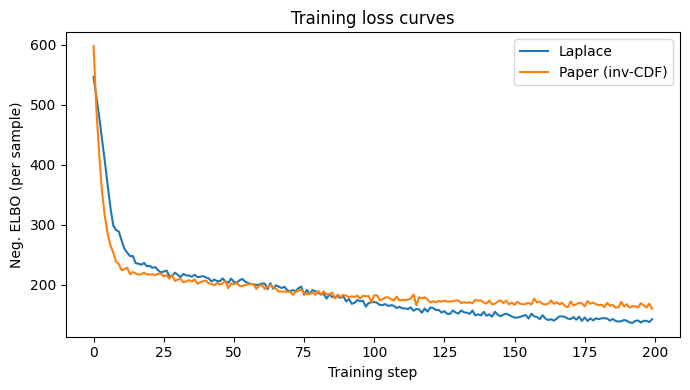

Saved loss plot → ./dirvae_out/training_loss_plot.png

[Reconstructions] Saving 4x8 grids for both methods
Saved recon grid: ./dirvae_out/recon_grid_laplace.png
Saved recon grid: ./dirvae_out/recon_grid_paper.png

[t-SNE] Computing on a small batch of latents (class-colored)


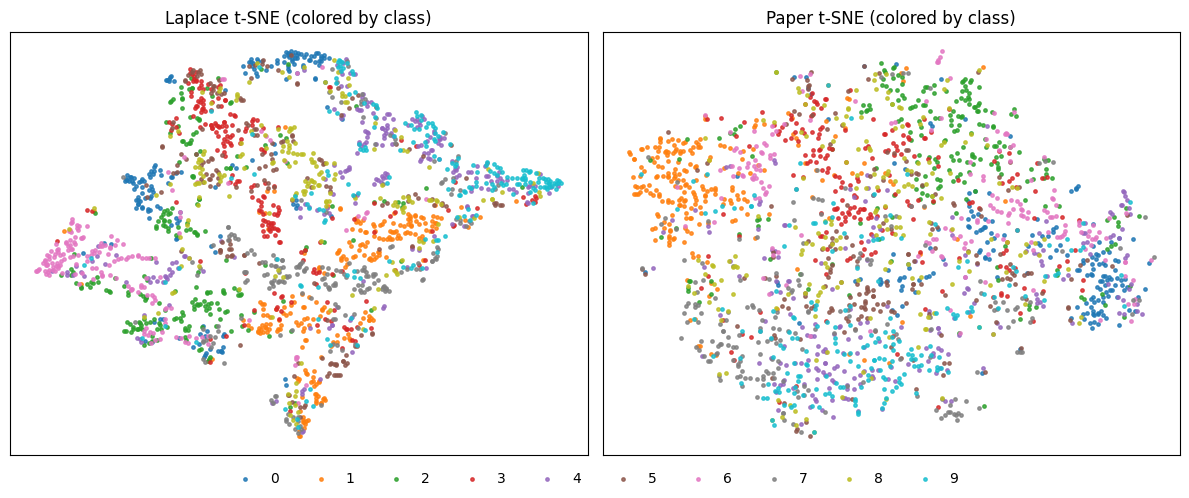

Saved: ./dirvae_out/tsne_latents_class_colored.png

[Histogram] Paper method latent values distribution (saved)


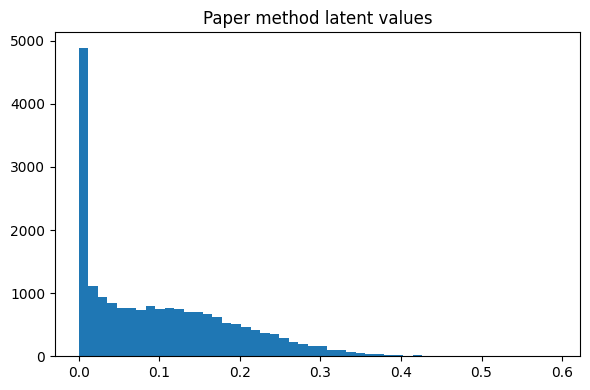

Saved: ./dirvae_out/hist_latent_paper.png

Done. Outputs in: ./dirvae_out


In [ ]:

from __future__ import annotations

import os
import random
from dataclasses import dataclass

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

try:
    from sklearn.manifold import TSNE
    SKLEARN_OK = True
except Exception:
    SKLEARN_OK = False

# ---------------------------
# Repro / basic config
# ---------------------------
@dataclass
class Config:
    batch_size:     int = 256
    test_batch_size:int = 512
    epochs:         int = 10                  # small for smoke tests; adjust as needed
    learning_rate:  float = 1e-3
    seed:           int = 10
    log_interval:   int = 50
    # Model sizes
    input_dim:      int = 28 * 28
    hidden_dim:     int = 512
    category:       int = 10                 # K (latent dimensionality on simplex)
    latent_dim:     int = 10
    # Prior / Dirichlet
    alpha:          float = 0.3              # scalar prior α per dim (tunable)
    # IO
    output_dir:     str = "./dirvae_out"
    # Short subset for quick runs
    train_subset:   int | None = 5000        # set None for full MNIST
    test_subset:    int | None = 2000
    # Device
    no_cuda:        bool = False

def setup_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ---------------------------
# Data loaders (MNIST)
# ---------------------------
def get_loaders(cfg: Config, device: torch.device):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    if cfg.train_subset is not None:
        train_dataset = Subset(train_dataset, list(range(min(cfg.train_subset, len(train_dataset)))))
    if cfg.test_subset is not None:
        test_dataset  = Subset(test_dataset, list(range(min(cfg.test_subset, len(test_dataset)))))

    num_workers = 2 if device.type == "cuda" else 0
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, drop_last=True,
                              num_workers=num_workers, pin_memory=(device.type == "cuda"))
    test_loader  = DataLoader(test_dataset,  batch_size=cfg.test_batch_size, shuffle=False, drop_last=False,
                              num_workers=num_workers, pin_memory=(device.type == "cuda"))
    return train_loader, test_loader

# ---------------------------
# Inverse-Gamma-CDF Dirichlet sampler
# ---------------------------
# Dirichlet as normalized MultiGamma (Section 2.2):
#   v_k ~ Gamma(α_k, β) with shared β; z_k = v_k / Σ_i v_i
# Section 3 (Knowles 2015): inverse Gamma CDF approximation for SGVB:
#   F^{-1}(u; α, β) ≈ β^{-1} * (u * α * Γ(α))^{1/α},  u~Uniform(0,1)
def dirichlet_rsample(alpha: torch.Tensor, method: str = "paper", eps: float = 1e-8) -> torch.Tensor:
    """
    Reparameterized Dirichlet sampler using inverse-Gamma-CDF approximation (Section 3).
    Args:
      alpha: shape [B, K], α_k > 0
      method: must be "paper" here
    Returns:
      z in the simplex, shape [B, K]
    """
    if method != "paper":
        raise ValueError(f"dirichlet_rsample(method='{method}') supports only 'paper' here.")
    alpha = alpha.clamp_min(1e-6)  # safety

    # Shared rate β=1. Sample Gamma(α_k, 1) via inverse CDF approximation:
    # v_k ≈ (u_k * α_k * Γ(α_k))^{1/α_k}, with u_k ~ Uniform(0,1).
    u = torch.rand_like(alpha).clamp_(min=eps, max=1.0 - eps)
    g_alpha = torch.exp(torch.lgamma(alpha))  # Γ(α) computed stably via lgamma
    v = (u * alpha * g_alpha).pow(1.0 / alpha)
    z = v / (v.sum(dim=-1, keepdim=True) + eps)
    return z

# ---------------------------
# Encoder / Decoder (MLP)
# ---------------------------
class DirVAEEncoder(nn.Module):
    """
    MLP encoder with parallel heads:
      - Laplace baseline heads: μ, logvar   (Eq. 5 context: Gaussian -> softmax)
      - Paper method head: α̂ > 0          (Section 3 inference sub-model)
    """
    def __init__(self, cfg: Config):
        super().__init__()
        D = cfg.input_dim
        H = cfg.hidden_dim
        K = cfg.category

        self.mlp = nn.Sequential(
            nn.Linear(D, H),
            nn.ReLU(inplace=True),
        )
        # Baseline (Laplace) heads
        self.fc_mu = nn.Linear(H, K)
        self.fc_logvar = nn.Linear(H, K)
        # Paper method head (α̂)
        self.fc_alpha = nn.Linear(H, K)
        self.softplus = nn.Softplus()

    def forward(self, x: torch.Tensor):
        x = x.view(x.size(0), -1)   # flatten 28x28
        h = self.mlp(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        alpha_hat = self.softplus(self.fc_alpha(h)) + 1e-6  # enforce α̂>0
        return mu, logvar, alpha_hat

class DirVAEDecoder(nn.Module):
    """
    MLP decoder.
    Contract:
      - For Laplace we feed the pre-softmax Gaussian z.
      - For Paper we feed log(z) so that any internal softmax would give z.
      - Output is in [0,1] via Sigmoid for MNIST BCE.
    """
    def __init__(self, cfg: Config):
        super().__init__()
        H = cfg.hidden_dim
        K = cfg.category
        D = cfg.input_dim

        self.mlp = nn.Sequential(
            nn.Linear(K, H),
            nn.ReLU(inplace=True),
            nn.Linear(H, D),
            nn.Sigmoid(),  # Bernoulli decoder
        )

    def forward(self, gauss_like: torch.Tensor) -> torch.Tensor:
        xhat = self.mlp(gauss_like)  # shape [B, 784]
        return xhat.view(-1, 1, 28, 28)

# ---------------------------
# Full model
# ---------------------------
class DirVAE(nn.Module):
    """
    Dirichlet Variational Auto-Encoder with two reparameterizations:
      - method="laplace": Gaussian -> softmax baseline (Eq. 5 context)
      - method="paper"  : inverse-Gamma-CDF MultiGamma -> normalized (Section 3)
                          with MultiGamma KL for ELBO (Eq. 3 / Eq. 7)
    """
    def __init__(self, cfg: Config, device: torch.device, method: str = "laplace"):
        super().__init__()
        self.cfg = cfg
        self.device = device
        self.method = method

        self.encoder = DirVAEEncoder(cfg)
        self.decoder = DirVAEDecoder(cfg)

        # Prior α buffer for Dirichlet/MultiGamma terms (used by "paper")
        self.register_buffer(
            "prior_alpha",
            torch.full((1, cfg.category), cfg.alpha, dtype=torch.float32, device=device)
        )

    def reparameterize_gauss(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor):
        """
        Returns:
          - method="laplace": recon_x, mu, logvar, gauss_z, dir_z
          - method="paper" : recon_x, alpha_hat, None, None, dir_z
        """
        mu, logvar, alpha_hat = self.encoder(x)

        if self.method == "laplace":
            gauss_z = self.reparameterize_gauss(mu, logvar)   # R^K
            dir_z = F.softmax(gauss_z, dim=1)                 # simplex
            recon_x = self.decoder(gauss_z)                   # decoder unchanged
            return recon_x, mu, logvar, gauss_z, dir_z

        elif self.method == "paper":
            dir_z = dirichlet_rsample(alpha_hat, method="paper")  # simplex
            # Minimal-change trick: feed log(z) → softmax(log z) == z if internal softmax existed
            recon_x = self.decoder(torch.log(dir_z + 1e-8))
            return recon_x, alpha_hat, None, None, dir_z

        else:
            raise ValueError(f"Unknown method: {self.method}")

    def loss_function(self, recon_x, x, p1, p2=None) -> torch.Tensor:
        """
        ELBO = Recon - KL. Minimize negative ELBO ⇒ BCE + KL.
        - method="laplace": KL(N(μ,σ²) || N(0,1))  [standard Gaussian KL]
        - method="paper" : MultiGamma KL (Eq. 3), used in ELBO (Eq. 7)
        """
        BCE = F.binary_cross_entropy(
            recon_x.view(-1, self.cfg.input_dim),
            x.view(-1, self.cfg.input_dim),
            reduction="sum"
        )

        if self.method == "laplace":
            mu, logvar = p1, p2
            KLD_per_sample = 0.5 * (logvar.exp() + mu.pow(2) - 1.0 - logvar).sum(dim=1)
            return BCE + KLD_per_sample.sum()

        elif self.method == "paper":
            alpha_hat = p1.clamp_min(1e-6)  # [B, K]
            alpha0 = self.prior_alpha.expand_as(alpha_hat)   # prior α (scalar per dim)
            # Eq. (3): sum logΓ(α) - sum logΓ(α̂) + sum (α̂ - α) ψ(α̂)
            kld_per_sample = (
                torch.lgamma(alpha0).sum(dim=1)
                - torch.lgamma(alpha_hat).sum(dim=1)
                + ((alpha_hat - alpha0) * torch.digamma(alpha_hat)).sum(dim=1)
            )
            return BCE + kld_per_sample.sum()

        else:
            raise ValueError(f"Unknown method: {self.method}")

# ---------------------------
# Training / evaluation loops
# ---------------------------
def train_one_epoch(model: DirVAE, loader: DataLoader, opt: optim.Optimizer, device, log_interval=50):
    model.train()
    total = 0.0
    n = 0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(device, non_blocking=True)
        opt.zero_grad()
        recon, p1, p2, _, _ = model(data)
        loss = model.loss_function(recon, data, p1, p2)
        (loss / len(data)).backward()
        opt.step()
        total += loss.item()
        n += len(data)
        if (batch_idx + 1) % log_interval == 0:
            print(f"  step {batch_idx+1:4d}/{len(loader)} | negELBO={total/n:.4f}")
    return total / n

@torch.no_grad()
def eval_epoch(model: DirVAE, loader: DataLoader, device):
    model.eval()
    total = 0.0
    n = 0
    for data, _ in loader:
        data = data.to(device, non_blocking=True)
        recon, p1, p2, _, _ = model(data)
        loss = model.loss_function(recon, data, p1, p2)
        total += loss.item()
        n += len(data)
    return total / n

# ---------------------------
# Utilities for quick demos
# ---------------------------
@torch.no_grad()
def reconstruct_grid(model: DirVAE, loader: DataLoader, device, tag: str, outdir: str):
    model.eval()
    data, _ = next(iter(loader))
    data = data.to(device)[:16]
    recon, p1, p2, _, _ = model(data)
    comp = torch.cat([data.cpu(), recon.cpu()], dim=0)
    os.makedirs(outdir, exist_ok=True)
    save_image(make_grid(comp, nrow=16), os.path.join(outdir, f"recon_grid_{tag}.png"))
    print(f"Saved recon grid: {os.path.join(outdir, f'recon_grid_{tag}.png')}")

@torch.no_grad()
def collect_latents_and_labels(model: DirVAE, loader: DataLoader, device, max_batches=10):
    """
    Collect a chunk of Dirichlet latents and their class labels.
    Returns: (Z [N,K] tensor, y [N] tensor)
    """
    model.eval()
    Z_list, Y_list = [], []
    cnt = 0
    for data, y in loader:
        data = data.to(device)
        _, _, _, _, dir_z = model(data)
        Z_list.append(dir_z.cpu())
        Y_list.append(y.cpu())
        cnt += 1
        if cnt >= max_batches:
            break
    return torch.cat(Z_list, dim=0), torch.cat(Y_list, dim=0)

# ---------------------------
# Main (tests, training, plots)
# ---------------------------
def main():
    cfg = Config()
    os.makedirs(cfg.output_dir, exist_ok=True)

    use_cuda = torch.cuda.is_available() and (not cfg.no_cuda)
    device = torch.device("cuda" if use_cuda else "cpu")
    setup_seed(cfg.seed)

    train_loader, test_loader = get_loaders(cfg, device)
    print(f"Device: {device} | Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

    # -----------------------
    # Moment test for sampler
    # -----------------------
    print("\n[Moment test] Dirichlet inverse-CDF sampler vs analytic moments")
    with torch.no_grad():
        K = cfg.category
        alpha = torch.rand(1, K) * 2.0 + 0.5   # α in (0.5, 2.5)
        N = 20000
        samples = []
        bs = 1024
        count = N
        while count > 0:
            b = min(bs, count)
            a = alpha.expand(b, -1)
            z = dirichlet_rsample(a, method="paper")
            samples.append(z)
            count -= b
        Z = torch.cat(samples, dim=0)
        a0 = alpha.sum()
        mean_true = alpha[0] / a0
        var_true = (alpha[0] * (a0 - alpha[0])) / (a0 * a0 * (a0 + 1.0))
        mean_emp = Z.mean(0)
        var_emp = Z.var(0, unbiased=False)
        print("  mean L1:", (mean_emp - mean_true).abs().mean().item())
        print("  var  L1:", (var_emp  - var_true ).abs().mean().item())

    # -----------------------
    # Build two models (baseline vs paper)
    # -----------------------
    model_lap = DirVAE(cfg, device, method="laplace").to(device)
    model_pap = DirVAE(cfg, device, method="paper").to(device)

    # -----------------------
    # Gradient flow test (alpha_hat receives gradients)
    # -----------------------
    print("\n[Gradient flow test] α̂ should receive gradients through inverse-CDF path")
    x = torch.randn(4, 1, 28, 28, device=device)
    model_pap.train()
    recon, alpha_hat, _, _, z = model_pap(x)
    loss = recon.sum()
    loss.backward()
    grad_ok = (alpha_hat.grad is not None) and (alpha_hat.grad.abs().sum().item() > 0)
    print("  alpha_hat.grad nonzero? ->", grad_ok)

    # -----------------------
    # Short training (~200 steps) and ELBO curves
    # -----------------------
    print("\n[Short training] ~200 steps per method; ELBO should decrease")

    def run_short(model, steps=200):
        opt = optim.Adam(model.parameters(), lr=cfg.learning_rate)
        elbos = []
        data_iter = iter(train_loader)
        model.train()
        for t in range(steps):
            try:
                data, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                data, _ = next(data_iter)
            data = data.to(device)
            opt.zero_grad()
            recon, p1, p2, _, _ = model(data)
            loss = model.loss_function(recon, data, p1, p2)
            (loss / len(data)).backward()
            opt.step()
            elbos.append((loss / len(data)).item())
            if (t + 1) % 50 == 0:
                print(f"  step {t+1:3d} | negELBO={elbos[-1]:.4f}")
        return elbos

    elap = run_short(model_lap, steps=200)
    epap = run_short(model_pap, steps=200)
    print(f"  Laplace: first={elap[0]:.4f} last={elap[-1]:.4f}")
    print(f"  Paper  : first={epap[0]:.4f} last={epap[-1]:.4f}")

    # -----------------------
    # Training loss plot (neg. ELBO per sample)
    # -----------------------
    plt.figure(figsize=(7,4))
    plt.plot(elap, label="Laplace")
    plt.plot(epap, label="Paper (inv-CDF)")
    plt.xlabel("Training step")
    plt.ylabel("Neg. ELBO (per sample)")
    plt.title("Training loss curves")
    plt.legend()
    plt.tight_layout()
    os.makedirs(cfg.output_dir, exist_ok=True)
    plt.savefig(os.path.join(cfg.output_dir, "training_loss_plot.png"), dpi=150)
    plt.show()
    print(f"Saved loss plot → {os.path.join(cfg.output_dir, 'training_loss_plot.png')}")

    # -----------------------
    # Recon grids (save PNGs)
    # -----------------------
    print("\n[Reconstructions] Saving 4x8 grids for both methods")
    reconstruct_grid(model_lap, test_loader, device, tag="laplace", outdir=cfg.output_dir)
    reconstruct_grid(model_pap, test_loader, device, tag="paper",   outdir=cfg.output_dir)

    # -----------------------
    # t-SNE of latent z, class-colored (requires sklearn)
    # -----------------------
    if SKLEARN_OK:
        print("\n[t-SNE] Computing on a small batch of latents (class-colored)")
        # Collect latents + labels
        Z_lap, y_lap = collect_latents_and_labels(model_lap, test_loader, device, max_batches=8)
        Z_pap, y_pap = collect_latents_and_labels(model_pap, test_loader, device, max_batches=8)
        Z_lap_np, y_lap_np = Z_lap.numpy(), y_lap.numpy()
        Z_pap_np, y_pap_np = Z_pap.numpy(), y_pap.numpy()

        # t-SNE projections
        tsne = TSNE(n_components=2, init="pca", learning_rate="auto")
        Y_lap = tsne.fit_transform(Z_lap_np)
        tsne = TSNE(n_components=2, init="pca", learning_rate="auto")
        Y_pap = tsne.fit_transform(Z_pap_np)

        # Plot with class colors
        colors = plt.cm.tab10.colors  # 10 distinct colors
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].set_title("Laplace t-SNE (colored by class)")
        axes[1].set_title("Paper t-SNE (colored by class)")
        for c in range(10):
            mask_l = (y_lap_np == c)
            mask_p = (y_pap_np == c)
            axes[0].scatter(Y_lap[mask_l, 0], Y_lap[mask_l, 1], s=6, color=colors[c % 10], label=str(c), alpha=0.8)
            axes[1].scatter(Y_pap[mask_p, 0], Y_pap[mask_p, 1], s=6, color=colors[c % 10], label=str(c), alpha=0.8)
        for ax in axes:
            ax.set_xticks([]); ax.set_yticks([])
        # One shared legend
        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=10, frameon=False)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        tsne_path = os.path.join(cfg.output_dir, "tsne_latents_class_colored.png")
        plt.savefig(tsne_path, dpi=160)
        plt.show()
        print(f"Saved: {tsne_path}")
    else:
        print("\n[t-SNE] sklearn not available; skipping.")

    # -----------------------
    # Histogram of latent values (paper)
    # -----------------------
    print("\n[Histogram] Paper method latent values distribution (saved)")
    with torch.no_grad():
        Zpap = collect_latents_and_labels(model_pap, test_loader, device, max_batches=20)[0].flatten().numpy()
        plt.figure(figsize=(6,4))
        plt.hist(Zpap, bins=50)
        plt.title("Paper method latent values")
        plt.tight_layout()
        hist_path = os.path.join(cfg.output_dir, "hist_latent_paper.png")
        plt.savefig(hist_path, dpi=160)
        plt.show()
        print(f"Saved: {hist_path}")

    print("\nDone. Outputs in:", cfg.output_dir)

if __name__ == "__main__":
    main()

# ---------------------------
# Notes on numerical stability
# ---------------------------
# - Clamp uniforms away from 0/1: u.clamp_(eps, 1-eps).
# - Compute Γ(α) via torch.lgamma(α) then exp; ψ(α) via torch.digamma(α).
# - Enforce α̂>0 with softplus + tiny offset: softplus(.) + 1e-6.
# - Normalize with a small eps in denominator.
# - Feeding log(z) to the decoder keeps the decoder unchanged (softmax(log z) == z).
# Mapping:
# - Eq. (5): Baseline Gaussian→softmax path (method="laplace").
# - Eq. (3): MultiGamma KL implemented in loss_function for "paper".
# - Eq. (7): ELBO = Recon BCE + MultiGamma KL term.
# - Section 3: Inverse Gamma CDF approximation used in dirichlet_rsample().


# DEN NYESTE CHAT KODE JEG PRØVER AT FÅ TIL AT FUNGERE:

In [2]:

# # MNIST: Gaussian VAE vs. Dirichlet VAE (inverse Gamma CDF) vs. CC-Placeholder
#
# This single cell runs end-to-end on Google Colab:
# - Downloads MNIST and makes a 45k/5k/10k split
# - Defines a shared CNN encoder/decoder backbone
# - Implements three bottlenecks:
#     1) Gaussian (standard Normal prior, diagonal posterior)
#     2) Dirichlet (Gamma composition + inverse Gamma CDF path; KL between MultiGamma’s)
#     3) CC placeholder (temperature-softmax of Gaussian logits; TODO swap with true CC later)
# - Trains each model (same hyperparams)
# - Logs loss curves (BCE, KL, ELBO), recon grids, and t-SNE of 5k test embeddings
# - Saves PNGs to `/content/outputs/`
#
# References in code comments (matching the user's attached paper):
# - Eq. (3): KL between MultiGamma’s
# - Eq. (5): Softmax–Laplace mapping (for fairness note)
# - Eq. (7): ELBO form for DirVAE (BCE + MultiGamma KL)
# - Inverse Gamma CDF sampler: F^{-1}(u; α, β) ≈ β^{-1}(u^α Γ(α))^{1/α}, u~U(0,1)
#
# Libraries: PyTorch, torchvision, scikit-learn (TSNE), matplotlib.
# GPU used if available. Seeds set for reproducibility.


import os
import math
import random
from dataclasses import dataclass, asdict
from typing import Tuple, Dict, List

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, utils as vutils

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -----------------------------
# Config
# -----------------------------
@dataclass
class Config:
    # Data & I/O
    data_root: str = "/content/data"
    out_dir: str = "/content/outputs"
    # Training
    batch_size: int = 256
    epochs: int = 20
    lr: float = 1e-3
    seed: int = 42
    num_workers: int = 2
    # Model
    img_c: int = 1
    img_h: int = 28
    img_w: int = 28
    latent_dim: int = 10  # K (match classes) for all models
    beta_gamma_rate: float = 1.0  # β shared Gamma rate for DirVAE
    # Backbone
    enc_ch: int = 32
    dec_ch: int = 32
    # Eval/plots
    tsne_samples: int = 5000
    log_interval: int = 50

cfg = Config()

# -----------------------------
# Reproducibility
# -----------------------------
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_all_seeds(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(cfg.out_dir, exist_ok=True)

# -----------------------------
# Data
# -----------------------------
transform = transforms.ToTensor()
mnist_full = datasets.MNIST(cfg.data_root, train=True, download=True, transform=transform)
test = datasets.MNIST(cfg.data_root, train=False, download=True, transform=transform)

# Make 45k train / 5k val from the 60k training set (remaining 10k is unused here;
# the official test set below provides the 10k test split).
train_len = 45_000
rest_len = len(mnist_full) - train_len  # 15_000
train, rest = random_split(
    mnist_full,
    [train_len, rest_len],
    generator=torch.Generator().manual_seed(cfg.seed),
)

# From the 15k "rest", take 5k for validation and drop the remaining 10k
val_len = 5_000
drop_len = rest_len - val_len  # 10_000
val, _ = random_split(
    rest,
    [val_len, drop_len],
    generator=torch.Generator().manual_seed(cfg.seed + 1),  # different seed for clarity
)

train_loader = DataLoader(train, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=cfg.batch_size, shuffle=False,
                        num_workers=cfg.num_workers, pin_memory=True)
test_loader = DataLoader(test, batch_size=cfg.batch_size, shuffle=False,
                         num_workers=cfg.num_workers, pin_memory=True)

print(f"Split sizes → train: {len(train)}, val: {len(val)}, test: {len(test)}")

# -----------------------------
# Shared CNN Encoder/Decoder
# -----------------------------
class EncoderCNN(nn.Module):
    """Shared CNN encoder -> latent 'stats head' provided by bottlenecks."""
    def __init__(self, latent_dim: int, ch: int = 32):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, ch, 4, 2, 1),  # 28 -> 14
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch*2, 4, 2, 1),  # 14 -> 7
            nn.BatchNorm2d(ch*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch*2, ch*4, 3, 2, 1),  # 7 -> 4
            nn.BatchNorm2d(ch*4),
            nn.ReLU(inplace=True),
        )
        self.out_dim = ch*4*4*4  # (channels)*(4*4)
        self.fc = nn.Linear(self.out_dim, 256)
        self.act = nn.ReLU(inplace=True)
        # Heads defined in bottlenecks

    def forward(self, x):
        h = self.feature(x)
        h = h.view(h.size(0), -1)
        h = self.act(self.fc(h))
        return h

class DecoderCNN(nn.Module):
    """Shared CNN decoder that maps latent -> image logits (use BCEWithLogitsLoss)."""
    def __init__(self, latent_dim: int, ch: int = 32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, ch*4*4*4),
            nn.ReLU(inplace=True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(ch*4, ch*2, 3, 2, 1, output_padding=1),  # 4 -> 7
            nn.BatchNorm2d(ch*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ch*2, ch, 4, 2, 1),  # 7 -> 14
            nn.BatchNorm2d(ch),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ch, 1, 4, 2, 1),  # 14 -> 28
            # No Sigmoid here; we'll use BCEWithLogitsLoss
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), -1, 4, 4)
        x_logits = self.deconv(h)
        return x_logits

# -----------------------------
# Bottlenecks
# -----------------------------
class GaussianBottleneck(nn.Module):
    """
    Standard Gaussian VAE bottleneck (diagonal posterior), prior N(0,I).
    """
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def forward(self, h):
        mu = self.mu(h)
        logvar = self.logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z, {"mu": mu, "logvar": logvar}

    def kl(self, aux):
        # KL( N(mu,diag(sigma^2)) || N(0,I) ) = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
        mu, logvar = aux["mu"], aux["logvar"]
        kl = -0.5 * torch.sum(1.0 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        return kl


class DirichletBottleneck(nn.Module):
    r"""
    Dirichlet VAE bottleneck with Gamma composition + inverse Gamma CDF reparameterization.

    Posterior: v_k ~ Gamma(α̂_k, β) independent (shared rate β), then y = v / sum(v) ~ Dirichlet(α̂).
    - Sampler (Knowles 2015; as cited): F^{-1}(u; α, β) ≈ β^{-1} (u^α Γ(α))^{1/α}, u ~ Uniform(0,1).
      Implemented in log-space for stability:
         log x = (α * log u + lgamma(α)) / α - log β = log u + lgamma(α)/α - log β.
      We clamp α̂ to avoid numerical issues and use softplus for positivity.

    Prior/Posterior KL (Eq. (3) in the DirVAE paper) between MultiGamma(α, β·1_K):
       KL(Q||P) = Σ_k [ log Γ(α_k) - log Γ(α̂_k) + (α̂_k - α_k) ψ(α̂_k) ],
       where ψ is digamma.

    Fair setup vs. Gaussian-Softmax note (Eq. (5)):
       With μ=0 and Σ=I in the Laplace mapping, α_k = 1 - 1/K; we set prior α accordingly.
       We also set β = 1 by default.
    """
    def __init__(self, latent_dim: int, beta_rate: float = 1.0, eps: float = 1e-6):
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = beta_rate
        self.eps = eps

        # Posterior α̂(x) > 0
        self.alpha_raw = nn.Linear(256, latent_dim)  # pass through softplus
        # Prior α (dimension-wise); using α_k = 1 - 1/K from Eq. (5) fairness note
        alpha0 = 1.0 - 1.0 / float(latent_dim)
        self.register_buffer("alpha_prior", torch.full((latent_dim,), alpha0))

    @staticmethod
    def _softplus(x):
        return F.softplus(x) + 1e-6  # keep > 0

    def _sample_multi_gamma(self, alpha_hat: torch.Tensor) -> torch.Tensor:
        """
        Sample K independent Gamma(α̂_k, β) using inverse CDF approximation.

        Input: alpha_hat (B, K) > 0
        Output: v (B, K) > 0
        """
        B, K = alpha_hat.shape
        # u in (0,1), avoid exact 0/1
        u = torch.clamp(torch.rand(B, K, device=alpha_hat.device), 1e-6, 1.0 - 1e-6)
        # log x = log( F^{-1}(u; α̂, β) )
        # = (α̂ * log u + lgamma(α̂)) / α̂ - log β  = log u + lgamma(α̂)/α̂ - log β
        log_x = torch.log(u) + torch.lgamma(alpha_hat) / alpha_hat - math.log(self.beta)
        v = torch.exp(log_x)
        return v

    def forward(self, h):
        alpha_hat = self._softplus(self.alpha_raw(h))  # (B,K)
        v = self._sample_multi_gamma(alpha_hat)       # (B,K)
        y = v / (v.sum(dim=1, keepdim=True) + self.eps)  # normalize to simplex
        return y, {"alpha_hat": alpha_hat}

    def kl(self, aux):
        """
        KL between Q=MultiGamma(α̂, β·1_K) and P=MultiGamma(α, β·1_K).
        Eq. (3): KL(Q||P) = Σ [ log Γ(α_k) - log Γ(α̂_k) + (α̂_k - α_k) * ψ(α̂_k) ].
        """
        alpha_hat = aux["alpha_hat"]  # (B,K)
        alpha = self.alpha_prior.view(1, -1).expand_as(alpha_hat)  # (B,K)
        term = torch.lgamma(alpha) - torch.lgamma(alpha_hat) + (alpha_hat - alpha) * torch.digamma(alpha_hat)
        kl = torch.sum(term, dim=1)
        return kl

    def embedding_for_tsne(self, aux):
        """
        Use the mean of Dirichlet: E[y_k] = α̂_k / Σ_j α̂_j for visualization.
        """
        alpha_hat = aux["alpha_hat"]
        return alpha_hat / (alpha_hat.sum(dim=1, keepdim=True) + self.eps)


class CCPlaceholderBottleneck(nn.Module):
    r"""
    Placeholder for a Continuous-Categorical (CC) bottleneck.

    For now, we do NOT implement the true CC distribution. Instead:
      - Produce Gaussian logits g(x) (μ only, no variance for simplicity)
      - Return softmax(g / τ) as the 'latent' living on the simplex
      - KL is set to the KL of a Gaussian posterior N(μ, I) vs. N(0, I) as a *placeholder*
        (or 0; here we keep a small regularization using an N(μ, I) trick)

    This is a drop-in module with the same interface so we can later swap in the true CC sampler
    without touching the rest of the code.

    TODOs:
      [ ] Replace softmax-of-Gaussian with true CC sampler (see project paper)
      [ ] Replace placeholder KL with CC’s exact KL/prior
    """
    def __init__(self, latent_dim: int, temperature: float = 0.5):
        super().__init__()
        self.latent_dim = latent_dim
        self.temperature = temperature
        self.logits = nn.Linear(256, latent_dim)  # produce logits

    def forward(self, h):
        g = self.logits(h)
        y = F.softmax(g / self.temperature, dim=1)
        return y, {"logits": g}

    def kl(self, aux):
        # Placeholder regularizer: treat logits as μ of N(μ, I) vs. N(0, I)
        mu = aux["logits"]
        kl = 0.5 * torch.sum(mu.pow(2), dim=1)  # encourages small logits
        return kl

    def embedding_for_tsne(self, aux):
        return F.softmax(aux["logits"] / self.temperature, dim=1)

# -----------------------------
# VAE Wrapper
# -----------------------------
class VAE(nn.Module):
    def __init__(self, bottleneck: nn.Module, latent_dim: int, enc_ch: int = 32, dec_ch: int = 32):
        super().__init__()
        self.encoder = EncoderCNN(latent_dim, ch=enc_ch)
        self.bottleneck = bottleneck
        self.decoder = DecoderCNN(latent_dim, ch=dec_ch)

    def forward(self, x):
        h = self.encoder(x)
        z, aux = self.bottleneck(h)
        x_logits = self.decoder(z)
        return x_logits, z, aux

# -----------------------------
# Training / Eval helpers
# -----------------------------
class Meter:
    def __init__(self):
        self.total = 0.0
        self.count = 0

    def update(self, val, n):
        self.total += float(val) * n
        self.count += n

    @property
    def avg(self):
        return self.total / max(1, self.count)

def bce_recon_loss(x_logits, x):
    # BCE with logits; sum over pixels, mean over batch done outside
    return F.binary_cross_entropy_with_logits(x_logits.view(x.size(0), -1),
                                              x.view(x.size(0), -1),
                                              reduction='sum')

def run_epoch(model, loader, optimizer=None, bottleneck_name: str = ""):
    train = optimizer is not None
    model.train(train)
    bce_meter, kl_meter, tot_meter = Meter(), Meter(), Meter()

    pbar = tqdm(loader, leave=False)
    for batch, (x, _) in enumerate(pbar):
        x = x.to(device)

        if train:
            optimizer.zero_grad()

        x_logits, z, aux = model(x)
        # Reconstruction loss
        bce = bce_recon_loss(x_logits, x)  # sum over batch
        # KL term (per-sample)
        kl_vec = model.bottleneck.kl(aux)  # (B,)
        kl = kl_vec.sum()
        # Total
        loss = bce + kl

        if train:
            loss.backward()
            optimizer.step()

        bsz = x.size(0)
        bce_meter.update(bce.item(), 1)
        kl_meter.update(kl.item(), 1)
        tot_meter.update(loss.item(), 1)

        if batch % cfg.log_interval == 0:
            pbar.set_description(f"[{bottleneck_name}] {'Train' if train else 'Eval '} BCE:{bce_meter.avg/bsz:.2f} KL:{kl_meter.avg/bsz:.2f}")

    # Return averages PER SAMPLE
    n_samples = len(loader.dataset)
    return {
        "bce": bce_meter.total / n_samples,
        "kl": kl_meter.total / n_samples,
        "total": tot_meter.total / n_samples,
    }

@torch.no_grad()
def make_recon_grid(model, loader, path: str, n: int = 10):
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device)[:n]
    x_logits, _, _ = model(x)
    x_rec = torch.sigmoid(x_logits)

    # top row originals; second row reconstructions
    grid = torch.cat([x, x_rec], dim=0)
    grid = vutils.make_grid(grid, nrow=n, padding=2)
    vutils.save_image(grid, path)

@torch.no_grad()
def collect_embeddings(model, loader, max_n: int = 5000):
    """
    Collect embeddings for t-SNE:
    - Gaussian: use μ (mean) as embedding (from aux)
    - Dirichlet: use E[y] = α̂ / Σ α̂
    - CC placeholder: use softmax(logits/τ)
    """
    model.eval()
    xs = []
    ys = []

    total = 0
    for x, y in loader:
        b = x.size(0)
        x = x.to(device)
        h = model.encoder(x)
        # forward through bottleneck without decoding
        if isinstance(model.bottleneck, GaussianBottleneck):
            mu = model.bottleneck.mu(h)
            emb = mu
        elif isinstance(model.bottleneck, DirichletBottleneck):
            alpha_hat = F.softplus(model.bottleneck.alpha_raw(h)) + 1e-6
            emb = alpha_hat / (alpha_hat.sum(dim=1, keepdim=True) + 1e-6)
        elif isinstance(model.bottleneck, CCPlaceholderBottleneck):
            logits = model.bottleneck.logits(h)
            emb = F.softmax(logits / model.bottleneck.temperature, dim=1)
        else:
            raise ValueError("Unknown bottleneck")
        xs.append(emb.detach().cpu())
        ys.append(y)
        total += b
        if total >= max_n:
            break

    X = torch.cat(xs, dim=0).numpy()[:max_n]
    Y = torch.cat(ys, dim=0).numpy()[:max_n]
    return X, Y

def plot_tsne(X, Y, title: str, path: str):
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30, n_iter=1000, verbose=0, random_state=cfg.seed)
    Z = tsne.fit_transform(X)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(Z[:,0], Z[:,1], c=Y, s=5, cmap='tab10', alpha=0.8)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()

# -----------------------------
# Experiment Runner
# -----------------------------
def train_and_evaluate(model_name: str) -> Dict[str, List[float]]:
    if model_name == "gvae":
        bottleneck = GaussianBottleneck(cfg.latent_dim)
    elif model_name == "dirvae":
        bottleneck = DirichletBottleneck(cfg.latent_dim, beta_rate=cfg.beta_gamma_rate)
    elif model_name == "cc":
        bottleneck = CCPlaceholderBottleneck(cfg.latent_dim, temperature=0.5)
    else:
        raise ValueError("Unknown model")

    model = VAE(bottleneck, cfg.latent_dim, enc_ch=cfg.enc_ch, dec_ch=cfg.dec_ch).to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

    history = {"train_bce": [], "train_kl": [], "train_total": [],
               "val_bce": [], "val_kl": [], "val_total": []}

    for epoch in range(1, cfg.epochs + 1):
        train_metrics = run_epoch(model, train_loader, optimizer=optimizer, bottleneck_name=model_name.upper())
        val_metrics = run_epoch(model, val_loader, optimizer=None, bottleneck_name=model_name.upper())

        history["train_bce"].append(train_metrics["bce"])
        history["train_kl"].append(train_metrics["kl"])
        history["train_total"].append(train_metrics["total"])

        history["val_bce"].append(val_metrics["bce"])
        history["val_kl"].append(val_metrics["kl"])
        history["val_total"].append(val_metrics["total"])

    # Recon grid on validation set
    make_recon_grid(model, val_loader, os.path.join(cfg.out_dir, f"recon_{model_name}.png"), n=10)

    # t-SNE on test embeddings
    X, Y = collect_embeddings(model, test_loader, max_n=cfg.tsne_samples)
    plot_tsne(X, Y, f"t-SNE ({model_name.upper()})", os.path.join(cfg.out_dir, f"tsne_{model_name}.png"))

    # Test metrics (for table)
    test_metrics = run_epoch(model, test_loader, optimizer=None, bottleneck_name=model_name.upper())
    history["test_bce"] = [test_metrics["bce"]]
    history["test_kl"] = [test_metrics["kl"]]
    history["test_total"] = [test_metrics["total"]]

    # Save checkpoint
    torch.save({"model_state": model.state_dict(),
                "cfg": asdict(cfg),
                "history": history},
               os.path.join(cfg.out_dir, f"ckpt_{model_name}.pt"))

    return history

# -----------------------------
# Run all experiments
# -----------------------------
print("Device:", device)
print("Config:", cfg)

hist_g = train_and_evaluate("gvae")
hist_d = train_and_evaluate("dirvae")
hist_c = train_and_evaluate("cc")

# -----------------------------
# Plot loss curves (three subplots)
# -----------------------------
epochs = range(1, cfg.epochs + 1)

plt.figure(figsize=(12, 4))
# Recon
plt.subplot(1, 3, 1)
plt.plot(epochs, hist_g["train_bce"], label="GVAE Train")
plt.plot(epochs, hist_g["val_bce"],   label="GVAE Val", linestyle="--")
plt.plot(epochs, hist_d["train_bce"], label="DirVAE Train")
plt.plot(epochs, hist_d["val_bce"],   label="DirVAE Val", linestyle="--")
plt.plot(epochs, hist_c["train_bce"], label="CC Train")
plt.plot(epochs, hist_c["val_bce"],   label="CC Val", linestyle="--")
plt.title("Reconstruction (BCE) ↓")
plt.xlabel("Epoch"); plt.ylabel("Avg per sample"); plt.legend(fontsize=8)

# KL
plt.subplot(1, 3, 2)
plt.plot(epochs, hist_g["train_kl"], label="GVAE Train")
plt.plot(epochs, hist_g["val_kl"],   label="GVAE Val", linestyle="--")
plt.plot(epochs, hist_d["train_kl"], label="DirVAE Train")
plt.plot(epochs, hist_d["val_kl"],   label="DirVAE Val", linestyle="--")
plt.plot(epochs, hist_c["train_kl"], label="CC Train")
plt.plot(epochs, hist_c["val_kl"],   label="CC Val", linestyle="--")
plt.title("KL term ↓")
plt.xlabel("Epoch"); plt.ylabel("Avg per sample"); plt.legend(fontsize=8)

# Total
plt.subplot(1, 3, 3)
plt.plot(epochs, hist_g["train_total"], label="GVAE Train")
plt.plot(epochs, hist_g["val_total"],   label="GVAE Val", linestyle="--")
plt.plot(epochs, hist_d["train_total"], label="DirVAE Train")
plt.plot(epochs, hist_d["val_total"],   label="DirVAE Val", linestyle="--")
plt.plot(epochs, hist_c["train_total"], label="CC Train")
plt.plot(epochs, hist_c["val_total"],   label="CC Val", linestyle="--")
plt.title("ELBO (BCE + KL) ↓")
plt.xlabel("Epoch"); plt.ylabel("Avg per sample"); plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(cfg.out_dir, "loss_curves.png"), dpi=150)
plt.show()

# -----------------------------
# Optional: tiny summary table
# -----------------------------
def last(arr): return float(arr[-1])

summary = {
    "Model": ["GVAE", "DirVAE", "CC"],
    "Test BCE": [last(hist_g["test_bce"]), last(hist_d["test_bce"]), last(hist_c["test_bce"])],
    "Test KL": [last(hist_g["test_kl"]), last(hist_d["test_kl"]), last(hist_c["test_kl"])],
    "Test ELBO": [last(hist_g["test_total"]), last(hist_d["test_total"]), last(hist_c["test_total"])],
}
import pandas as pd
df = pd.DataFrame(summary)
print("\nFinal test metrics (avg per sample):")
print(df.to_string(index=False))

print(f"\nSaved files in {cfg.out_dir}:")
for name in ["recon_gvae.png", "recon_dirvae.png", "recon_cc.png",
             "tsne_gvae.png", "tsne_dirvae.png", "tsne_cc.png", "loss_curves.png",
             "ckpt_gvae.pt", "ckpt_dirvae.pt", "ckpt_cc.pt"]:
    print(" -", os.path.join(cfg.out_dir, name))


Split sizes → train: 45000, val: 5000, test: 10000
Device: cuda
Config: Config(data_root='/content/data', out_dir='/content/outputs', batch_size=256, epochs=20, lr=0.001, seed=42, num_workers=2, img_c=1, img_h=28, img_w=28, latent_dim=10, beta_gamma_rate=1.0, enc_ch=32, dec_ch=32, tsne_samples=5000, log_interval=50)


  0%|          | 0/176 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([256, 784])) must be the same as input size (torch.Size([256, 1024]))